In [10]:
import pandas as pd
import numpy as np
import wrds
from datetime import datetime
import matplotlib.pyplot as plt

# =============================================================================
# ÉTAPE 1: CONNEXION WRDS ET PARAMÈTRES
# =============================================================================
print("🚀 Étape 1: Connexion à WRDS et définition des paramètres...")
with open("wrds_credentials.txt", "r") as f:
    lines = f.read().splitlines()
    user = lines[0]
    print(user)
    pwd = lines[1]
    print(pwd)
db = wrds.Connection(wrds_username=user, wrds_password=pwd)
end_date = '2025-01-30'
trading_days = 1276
start_date_approx = (pd.to_datetime(end_date) - pd.to_timedelta(trading_days * 1.8, unit='d')).strftime('%Y-%m-%d')
num_stocks = 25
print("✅ Connexion et paramètres définis.")

# =============================================================================
# ÉTAPE 2: SÉLECTION DE L'UNIVERS (TOP 25 S&P 500)
# =============================================================================
print("\n🚀 Étape 2: Sélection de l'univers des 25 plus grosses capitalisations...")
query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
last_trading_day_str = last_date_df['last_date'][0].strftime('%Y-%m-%d')
end_date = last_trading_day_str
query_universe = f"""
    WITH sp500_constituents AS (SELECT permno FROM crsp.msp500list WHERE '{end_date}' BETWEEN start AND ending),
    market_cap AS (
        SELECT a.permno, ABS(a.prc * a.shrout) as mktcap
        FROM crsp.dsf AS a JOIN sp500_constituents AS b ON a.permno = b.permno
        WHERE a.date = '{end_date}' AND a.prc IS NOT NULL AND a.shrout IS NOT NULL
    )
    SELECT permno FROM market_cap ORDER BY mktcap DESC LIMIT {num_stocks}
"""
top_25_permno = db.raw_sql(query_universe)['permno'].tolist()
permno_tuple = tuple(top_25_permno)
print(f"✅ Univers de {len(top_25_permno)} actions identifié.")

# =============================================================================
# ÉTAPE 3: TÉLÉCHARGEMENT DES DONNÉES HISTORIQUES
# =============================================================================
print("\n🚀 Étape 3: Téléchargement des données (avec COMNAM et TICKER)...")
query_data = f"""
    SELECT a.permno, a.date, a.ret, b.dlret, c.comnam, c.ticker
    FROM crsp.dsf AS a
    LEFT JOIN crsp.dsedelist AS b ON a.permno = b.permno AND a.date = b.dlstdt
    LEFT JOIN crsp.msenames AS c ON a.permno = c.permno AND a.date BETWEEN c.namedt AND c.nameendt
    WHERE a.permno IN {permno_tuple} AND a.date BETWEEN '{start_date_approx}' AND '{end_date}'
"""
daily_data = db.raw_sql(query_data, date_cols=['date'])
daily_data['comnam'] = daily_data.groupby('permno')['comnam'].transform(lambda x: x.ffill().bfill())
daily_data['ticker'] = daily_data.groupby('permno')['ticker'].transform(lambda x: x.ffill().bfill())
permno_to_name = daily_data.drop_duplicates('permno').set_index('permno')['comnam'].to_dict()
permno_to_ticker = daily_data.drop_duplicates('permno').set_index('permno')['ticker'].to_dict()
all_dates = sorted(daily_data['date'].unique())
final_dates = all_dates[-trading_days:]
daily_data = daily_data[daily_data['date'].isin(final_dates)]
print("✅ Téléchargement terminé.")
db.close()
print("🔒 Connexion WRDS fermée.")

# =============================================================================
# ÉTAPE 4: NETTOYAGE ET CRÉATION DE LA MATRICE
# =============================================================================
print("\n🚀 Étape 4: Nettoyage et construction de la matrice finale...")
daily_data['ret'] = pd.to_numeric(daily_data['ret'], errors='coerce').fillna(0)
daily_data['dlret'] = pd.to_numeric(daily_data['dlret'], errors='coerce').fillna(0)
daily_data['effective_ret'] = (1 + daily_data['ret']) * (1 + daily_data['dlret']) - 1
daily_data['price_relative'] = 1 + daily_data['effective_ret']
final_matrix_relatives = daily_data.pivot(index='date', columns='permno', values='price_relative')
final_matrix_relatives.ffill(inplace=True)
final_matrix_relatives.fillna(1.0, inplace=True)
print("✅ Matrice des relatifs de prix construite !")
print("\n--- Actions dans l'univers du backtest ---")
tickers_in_matrix = [permno_to_ticker.get(p, str(p)) for p in final_matrix_relatives.columns]
print(tickers_in_matrix)
print(f"Shape de la matrice : {final_matrix_relatives.shape}")
print("------------------------------------------\n")


🚀 Étape 1: Connexion à WRDS et définition des paramètres...
tr2829
Valotirosa03@
Loading library list...
Loading library list...
Done
✅ Connexion et paramètres définis.

🚀 Étape 2: Sélection de l'univers des 25 plus grosses capitalisations...
✅ Univers de 25 actions identifié.

🚀 Étape 3: Téléchargement des données (avec COMNAM et TICKER)...
Done
✅ Connexion et paramètres définis.

🚀 Étape 2: Sélection de l'univers des 25 plus grosses capitalisations...
✅ Univers de 25 actions identifié.

🚀 Étape 3: Téléchargement des données (avec COMNAM et TICKER)...
✅ Téléchargement terminé.
🔒 Connexion WRDS fermée.

🚀 Étape 4: Nettoyage et construction de la matrice finale...
✅ Matrice des relatifs de prix construite !

--- Actions dans l'univers du backtest ---
['ORCL', 'MSFT', 'XOM', 'FB', 'GOOG', 'AAPL', 'PG', 'JNJ', 'JPM', 'LLY', 'WMT', 'BAC', 'HD', 'BRK', 'AMZN', 'NVDA', 'COST', 'NFLX', 'CRM', 'GOOGL', 'MA', 'V', 'UNH', 'AVGO', 'TSLA']
Shape de la matrice : (1276, 25)
-------------------------

In [11]:

# =============================================================================
# FONCTION DE STRATÉGIE ANTICOR(w) - VECTORISÉE + OPTIONS DE SORTIE
# =============================================================================
def run_anticor_strategy(
    price_relatives: pd.DataFrame,
    w: int,
    permno_to_ticker: dict,
    debug_days: int = 0,
    returns_only: bool = False,
    force_start_at_index: int | None = None,
    dtype=np.float32,
):
    """
    Exécute la stratégie ANTICOR(w) de manière vectorisée et efficace.

    Paramètres:
    - price_relatives: DataFrame (index=dates, colonnes=permno), valeurs ~ 1 + ret.
    - w: taille de fenêtre.
    - permno_to_ticker: mapping pour l'affichage final.
    - debug_days: nombre de jours initiaux avec prints explicatifs.
    - returns_only: si True, ne construit pas l'historique détaillé des poids (utile pour ANTI² couche 1).
    - force_start_at_index: si fourni (int), ne commence qu'à max(2*w, force_start_at_index).
    - dtype: type flottant interne (np.float32 conseillé).

    Retour:
    - DataFrame avec 'daily_profit' (+ colonnes de poids si returns_only=False).
    """
    # Dimensions et conversions
    dates = price_relatives.index
    assets = price_relatives.columns
    m = price_relatives.shape[1]
    n = len(price_relatives)

    pr = price_relatives.to_numpy(dtype=dtype, copy=False)
    log_relatives = np.log(pr).astype(dtype, copy=False)

    # Point de départ
    t_start = 2 * w
    if force_start_at_index is not None:
        t_start = max(t_start, int(force_start_at_index))
    if t_start >= n:
        raise ValueError("Pas assez d'observations pour la fenêtre demandée.")

    # Préallocations
    out_len = n - t_start
    daily_returns_history = np.empty(out_len, dtype=dtype)
    dates_history = np.empty(out_len, dtype=object)
    store_weights = not returns_only
    if store_weights:
        weights_history = np.empty((out_len, m), dtype=dtype)

    # Poids initiaux
    b_t = np.full(m, 1.0 / m, dtype=dtype)

    for k, t in enumerate(range(t_start, n)):
        is_debug_day = k < debug_days

        # 1) rendement quotidien avec b_t décidé la veille
        day_ret = (b_t * pr[t]).sum() - 1.0
        daily_returns_history[k] = day_ret
        dates_history[k] = dates[t]
        if store_weights:
            weights_history[k, :] = b_t

        # 2) rebalancement (après avoir observé la journée t)
        b_t_reb = b_t * pr[t]
        denom = b_t_reb.sum()
        if denom <= 0:
            # Sécurité numérique
            b_t_reb = np.full(m, 1.0 / m, dtype=dtype)
        else:
            b_t_reb = b_t_reb / denom

        # 3) fenêtres en log pour corrélations
        # X1: [t-2w+1 .. t-w], X2: [t-w+1 .. t]
        X1 = log_relatives[t - 2 * w + 1 : t - w + 1, :]  # (w, m)
        X2 = log_relatives[t - w + 1 : t + 1, :]          # (w, m)

        # Moyennes (mu2) sur X2 (par colonne)
        mu2 = X2.mean(axis=0)

        # Standardisation colonne-par-colonne, ddof=1
        # std=0 -> colonne à 0 (évite divisions)
        X1_mean = X1.mean(axis=0)
        X2_mean = X2.mean(axis=0)
        X1_std = X1.std(axis=0, ddof=1)
        X2_std = X2.std(axis=0, ddof=1)

        with np.errstate(invalid="ignore", divide="ignore"):
            X1z = (X1 - X1_mean) / X1_std
            X2z = (X2 - X2_mean) / X2_std
        # Remplacer NaN/inf issus des std~0
        X1z = np.where(np.isfinite(X1z), X1z, 0.0)
        X2z = np.where(np.isfinite(X2z), X2z, 0.0)

        # 4) matrice des corrélations m_cor (m x m) via produit matriciel
        # corr(i,j) = <X1z[:,i], X2z[:,j]> / (w-1)
        m_cor = (X1z.T @ X2z) / max(w - 1, 1)

        # 5) matrice des revendications (claims)
        # Conditions: i != j, mu2[i] > mu2[j], m_cor[i,j] > 0
        mu_cmp = mu2[:, None] > mu2[None, :]
        pos_corr = m_cor > 0
        offdiag = ~np.eye(m, dtype=bool)

        # Ajustements diagonaux: si m_cor[i,i] < 0, on ajoute -m_cor[i,i]
        diag = np.diag(m_cor)
        extra = -np.minimum(diag, 0.0)  # >=0
        # claims_ij = m_cor_ij + extra_i + extra_j (quand masques vrais), sinon 0
        claims = m_cor + extra[:, None] + extra[None, :]
        mask = offdiag & mu_cmp & pos_corr
        # Appliquer le masque, sinon 0
        claims = np.where(mask, claims, 0.0)

        # 6) redistribution vectorisée
        total_out = claims.sum(axis=1)
        has_out = total_out > 0
        # Matrice de distribution P (lignes qui sortent, somme_ligne=1)
        P = np.zeros_like(claims, dtype=dtype)
        P[has_out, :] = claims[has_out, :] / total_out[has_out, None]

        # Sortant: lignes has_out -> tout le poids de b_t_reb de i est redistribué
        b_next = np.zeros_like(b_t_reb)
        # Inflow = somme_i b_t_reb[i] * P[i, j]
        b_next += b_t_reb @ P
        # Les lignes sans outflow gardent leur poids
        b_next += b_t_reb * (~has_out)

        # Normalisation
        s = b_next.sum()
        if s <= 0:
            b_t = np.full(m, 1.0 / m, dtype=dtype)
        else:
            b_t = b_next / s

        if is_debug_day:
            # Quelques impressions synthétiques sans coût excessif
            top_idx = np.argsort(-b_t_reb)[:5]
            tickers = [permno_to_ticker.get(assets[i], str(assets[i])) for i in top_idx]
            print(f"\n==================== JOUR: {dates[t].date()} (t={t}) ====================")
            print("Top pondérations (au rebal.):")
            for i, wt in zip(tickers, b_t_reb[top_idx]):
                print(f"  - {i:<6}: {wt:.2%}")

    # Assemblage des résultats
    results_df = pd.DataFrame(daily_returns_history, index=pd.Index(dates_history), columns=["daily_profit"])

    if store_weights:
        # Colonnes de poids avec tickers
        col_names = [f"weight_{permno_to_ticker.get(a, a)}" for a in assets]
        weights_df = pd.DataFrame(weights_history, index=results_df.index, columns=col_names)
        return pd.concat([results_df, weights_df], axis=1)
    else:
        return results_df


In [12]:


# =============================================================================
# FONCTION POUR LA STRATÉGIE LISSÉE ANTI¹ (BAH(ANTICOR)) - OPTIMISÉE
# =============================================================================

def run_anti1_strategy(price_relatives: pd.DataFrame, max_W: int, permno_to_ticker: dict):
    """
    Exécute la stratégie lissée ANTI¹ (BAH(ANTICOR)).
    Moyenne les portefeuilles de ANTICOR(w) pour w allant de 2 à max_W.
    Optimisations:
    - Démarre tous les experts à la même date (2*max_W) pour éviter du calcul jeté.
    - Moyenne des poids par somme incrémentale au lieu d'un concat/groupby coûteux.
    """
    print(f"🚀 Lancement du backtest pour ANTI¹ avec W_max={max_W}...")

    # Point de départ commun
    start_idx = 2 * max_W
    if start_idx >= len(price_relatives.index):
        raise ValueError("Pas assez d'observations pour ANTI¹ avec ce W_max.")
    start_date = price_relatives.index[start_idx]

    # Accumulation incrémentale des poids alignés
    sum_weights = None
    expert_count = 0

    for w in range(2, max_W + 1):
        print(f"  - Calcul de l'expert ANTICOR(w={w})...")
        temp_results = run_anticor_strategy(
            price_relatives, w, permno_to_ticker, debug_days=0,
            returns_only=False, force_start_at_index=start_idx
        )
        # Diagnostic compact
        expert_profit_cumule = (1 + temp_results['daily_profit']).prod()
        print(f"    -> Profit cumulé pour w={w} (aligné): {expert_profit_cumule:.4f}")

        df_weights = temp_results.filter(like='weight_')
        if sum_weights is None:
            sum_weights = df_weights.copy()
        else:
            sum_weights = sum_weights.add(df_weights, fill_value=0.0)
        expert_count += 1

    # Moyenne simple des poids des experts (déjà alignés sur start_date)
    mean_weights_df = sum_weights / float(expert_count)

    # Préparer les rendements des actifs alignés
    price_relatives_renamed = price_relatives.rename(columns=permno_to_ticker)
    daily_returns_assets = price_relatives_renamed.loc[start_date:] - 1
    # Harmoniser les noms de colonnes avec mean_weights_df
    daily_returns_assets.columns = [f'weight_{col}' for col in daily_returns_assets.columns]

    # Rendement quotidien de la stratégie ANTI¹
    anti1_daily_returns = (mean_weights_df * daily_returns_assets).sum(axis=1)

    results_df = pd.DataFrame(anti1_daily_returns, columns=['daily_profit'])
    results_df['profit_cumule'] = (1 + results_df['daily_profit']).cumprod()

    # Joindre les poids moyens pour analyse
    results_df = results_df.join(mean_weights_df)

    print("✅ Backtest ANTI¹ terminé !")
    return results_df


In [13]:


# =============================================================================
# ÉTAPE 5: EXÉCUTION DU BACKTEST ANTICOR(w=30)
# =============================================================================
print("\n🚀 Étape 5: Lancement du backtest de la stratégie Anticor(w=30)...")
resultats_strategie = run_anticor_strategy(final_matrix_relatives, w=30, permno_to_ticker=permno_to_ticker, debug_days=3)
resultats_strategie['profit_cumule'] = (1 + resultats_strategie['daily_profit']).cumprod()
print("\n✅ Backtest Anticor terminé !")



🚀 Étape 5: Lancement du backtest de la stratégie Anticor(w=30)...

==================== JOUR: 2020-03-04 (t=60) ====================
Top pondérations (au rebal.):
  - UNH   : 4.24%
  - LLY   : 4.13%
  - NVDA  : 4.10%
  - COST  : 4.06%
  - JNJ   : 4.06%

==================== JOUR: 2020-03-05 (t=61) ====================
Top pondérations (au rebal.):
  - JPM   : 18.72%
  - BAC   : 18.56%
  - XOM   : 12.15%
  - PG    : 7.92%
  - FB    : 4.35%

==================== JOUR: 2020-03-06 (t=62) ====================
Top pondérations (au rebal.):
  - JPM   : 30.91%
  - BAC   : 23.82%
  - XOM   : 20.22%
  - PG    : 8.89%
  - AVGO  : 2.97%

✅ Backtest Anticor terminé !


In [14]:


# =============================================================================
# NOUVELLE ÉTAPE : EXÉCUTION DU BACKTEST ANTI¹ (W_max=30)
# =============================================================================
print("\n🚀 Lancement du backtest de la stratégie ANTI¹ (lissée)...")
resultats_anti1 = run_anti1_strategy(final_matrix_relatives, max_W=30, permno_to_ticker=permno_to_ticker)




🚀 Lancement du backtest de la stratégie ANTI¹ (lissée)...
🚀 Lancement du backtest pour ANTI¹ avec W_max=30...
  - Calcul de l'expert ANTICOR(w=2)...
    -> Profit cumulé pour w=2 (aligné): 5.9211
  - Calcul de l'expert ANTICOR(w=3)...
    -> Profit cumulé pour w=2 (aligné): 5.9211
  - Calcul de l'expert ANTICOR(w=3)...
    -> Profit cumulé pour w=3 (aligné): 5.3610
  - Calcul de l'expert ANTICOR(w=4)...
    -> Profit cumulé pour w=3 (aligné): 5.3610
  - Calcul de l'expert ANTICOR(w=4)...
    -> Profit cumulé pour w=4 (aligné): 5.9168
  - Calcul de l'expert ANTICOR(w=5)...
    -> Profit cumulé pour w=4 (aligné): 5.9168
  - Calcul de l'expert ANTICOR(w=5)...
    -> Profit cumulé pour w=5 (aligné): 5.8773
  - Calcul de l'expert ANTICOR(w=6)...
    -> Profit cumulé pour w=5 (aligné): 5.8773
  - Calcul de l'expert ANTICOR(w=6)...
    -> Profit cumulé pour w=6 (aligné): 2.2914
  - Calcul de l'expert ANTICOR(w=7)...
    -> Profit cumulé pour w=6 (aligné): 2.2914
  - Calcul de l'expert ANTICO

In [15]:

# =============================================================================
# ÉTAPE 6: CALCUL DES BENCHMARKS (MEILLEUR ACTIF ET EWP)
# =============================================================================
print("\n🚀 Étape 6: Calcul des benchmarks (Meilleur Actif et Portefeuille Équipondéré)...")

df_prix_charges = 100 * final_matrix_relatives.cumprod()
df_prix_charges.rename(columns=permno_to_ticker, inplace=True)

start_date_strat = resultats_anti1.index[0] 

# --- Meilleur Actif (Buy & Hold) ---
best_performing_ticker = df_prix_charges.iloc[-1].idxmax()
best_asset_perf = (df_prix_charges[best_performing_ticker].loc[start_date_strat:] / df_prix_charges[best_performing_ticker].loc[start_date_strat])

# --- Portefeuille Équipondéré (EWP - Equally Weighted Portfolio) ---
ewp_daily_returns = final_matrix_relatives.mean(axis=1) - 1
ewp_perf = (1 + ewp_daily_returns.loc[start_date_strat:]).cumprod()

print(f"✅ Benchmarks calculés. Meilleur actif : {best_performing_ticker}")



🚀 Étape 6: Calcul des benchmarks (Meilleur Actif et Portefeuille Équipondéré)...
✅ Benchmarks calculés. Meilleur actif : NVDA



📊 Étape 7: Génération du graphique et des indicateurs de performance...


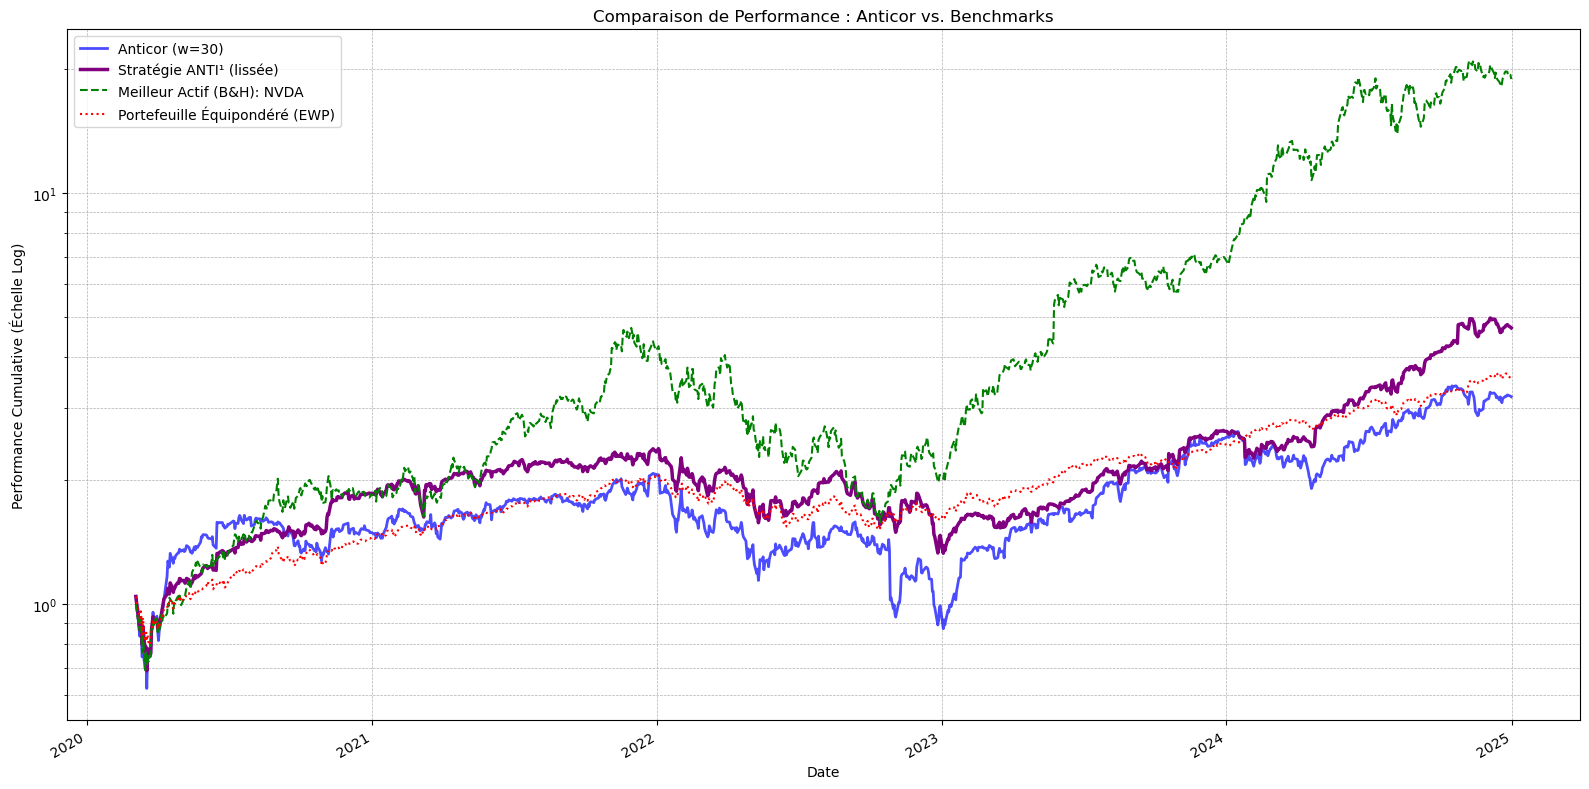

                       Rendement Cumulé  Rendement Annualisé  \
Anticor (w=30)                 2.195306             0.272195   
ANTI¹ (lissée)                 3.700552             0.378142   
EWP                            2.534950             0.299108   
Meilleur Actif (NVDA)         17.947088             0.840652   

                       Volatilité Annualisée  Ratio de Sharpe  Max Drawdown  \
Anticor (w=30)                      0.454186         0.599302     -0.581222   
ANTI¹ (lissée)                      0.356545         1.060575     -0.443713   
EWP                                 0.223312         1.339415     -0.259435   
Meilleur Actif (NVDA)               0.539621         1.557857     -0.663352   

                       Ratio de Calmar  
Anticor (w=30)                0.468315  
ANTI¹ (lissée)                0.852223  
EWP                           1.152922  
Meilleur Actif (NVDA)         1.267280  


In [16]:

# =============================================================================
# ÉTAPE 7: VISUALISATION ET KPIS (MISE À JOUR)
# =============================================================================
print("\n📊 Étape 7: Génération du graphique et des indicateurs de performance...")
fig, ax = plt.subplots(figsize=(16, 8))

# 1. Stratégie Anticor(w=30)
resultats_strategie['profit_cumule'].loc[start_date_strat:].plot(ax=ax, label='Anticor (w=30)', lw=2.0, color='blue', alpha=0.7)

# 2. Stratégie ANTI¹ (lissée)
resultats_anti1['profit_cumule'].plot(ax=ax, label='Stratégie ANTI¹ (lissée)', lw=2.5, color='purple')

# 3. Meilleur Actif (B&H)
best_asset_perf.plot(ax=ax, label=f'Meilleur Actif (B&H): {best_performing_ticker}', linestyle='--', color='green')

# 4. Portefeuille Équipondéré (EWP)
ewp_perf.plot(ax=ax, label='Portefeuille Équipondéré (EWP)', linestyle=':', color='red')

ax.set_title('Comparaison de Performance : Anticor vs. Benchmarks')
ax.set_ylabel('Performance Cumulative (Échelle Log)')
ax.set_xlabel('Date')
ax.set_yscale('log')
ax.legend(loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- Calcul et affichage des KPIs ---
def calculate_performance_metrics(daily_returns_series, risk_free_rate=0.0):
    trading_days_per_year = 252
    cumulative_return = (1 + daily_returns_series).prod() - 1
    num_days = len(daily_returns_series)
    annualized_return = (1 + cumulative_return) ** (trading_days_per_year / num_days) - 1
    annualized_volatility = daily_returns_series.std() * np.sqrt(trading_days_per_year)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility > 0 else 0
    
    cumulative_series = (1 + daily_returns_series).cumprod()
    peak = cumulative_series.expanding(min_periods=1).max()
    drawdown = (cumulative_series - peak) / peak
    max_drawdown = drawdown.min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0
    
    return {
        "Rendement Cumulé": cumulative_return, "Rendement Annualisé": annualized_return,
        "Volatilité Annualisée": annualized_volatility, "Ratio de Sharpe": sharpe_ratio,
        "Max Drawdown": max_drawdown, "Ratio de Calmar": calmar_ratio
    }

metrics = {}
metrics['Anticor (w=30)'] = calculate_performance_metrics(resultats_strategie['daily_profit'].loc[start_date_strat:])
metrics['ANTI¹ (lissée)'] = calculate_performance_metrics(resultats_anti1['daily_profit'])
metrics['EWP'] = calculate_performance_metrics(ewp_daily_returns.loc[start_date_strat:])
metrics[f'Meilleur Actif ({best_performing_ticker})'] = calculate_performance_metrics(best_asset_perf.pct_change().dropna())

results_table = pd.DataFrame(metrics).T
print(results_table)

In [17]:
import pandas as pd
import numpy as np

print("================ BEGINNING ANTI2 STRATEGY ================")


def run_anti2_strategy(price_relatives: pd.DataFrame, max_W: int, permno_to_ticker: dict):
    """
    Exécute la stratégie composée ANTI² (BAH(ANTICOR(ANTICOR))).

    Optimisations:
    - Couche 1: appelle ANTICOR(w) en mode returns_only + alignement commun (2*max_W).
    - Couche 2: réutilise ANTI¹ optimisée sur la matrice des "experts".
    """
    print(f"🚀 Lancement du backtest de la stratégie ANTI² avec W_max={max_W}...")

    # --- Couche 1 : Exécuter ANTICOR(w) sur les actions ---
    expert_daily_returns = {}
    start_idx = 2 * max_W

    print("  - Étape 1/3 : Calcul des experts de la Couche 1 (ANTICOR sur Actions)...")
    for w in range(2, max_W + 1):
        temp_results = run_anticor_strategy(
            price_relatives, w, permno_to_ticker,
            debug_days=0, returns_only=True, force_start_at_index=start_idx
        )
        expert_daily_returns[f"w_{w}"] = temp_results['daily_profit']
        if w % 5 == 0 or w == max_W:
            print(f"    -> Expert de Couche 1 (w={w}) calculé.")

    # Créer le DataFrame des rendements des experts de la couche 1 (déjà alignés)
    anti1_returns_df = pd.DataFrame(expert_daily_returns)

    # --- Couche 2 : Préparer les données pour ANTI¹ sur les experts ---
    print("\n  - Étape 2/3 : Préparation de la matrice des relatifs pour la Couche 2...")
    anti1_relatives_matrix = 1 + anti1_returns_df.fillna(0.0)

    # Mapping d'identité pour ces "tickers" d'experts
    w_to_ticker_map = {col: col for col in anti1_relatives_matrix.columns}

    # --- Couche 3 : Exécuter ANTI¹ sur les rendements des experts de la Couche 1 ---
    print("  - Étape 3/3 : Lancement de la Couche 2 (ANTI¹ sur Experts)...")
    resultats_anti2 = run_anti1_strategy(
        price_relatives=anti1_relatives_matrix,
        max_W=max_W,
        permno_to_ticker=w_to_ticker_map,
    )

    print("\n✅ Backtest ANTI² terminé !")
    return resultats_anti2


# --- Exécution ---
# Assurez-vous que 'final_matrix_relatives' et 'permno_to_ticker' existent
resultats_anti2 = run_anti2_strategy(final_matrix_relatives, max_W=30, permno_to_ticker=permno_to_ticker)

================ BEGINNING ANTI2 STRATEGY ================
🚀 Lancement du backtest de la stratégie ANTI² avec W_max=30...
  - Étape 1/3 : Calcul des experts de la Couche 1 (ANTICOR sur Actions)...
    -> Expert de Couche 1 (w=5) calculé.
    -> Expert de Couche 1 (w=5) calculé.
    -> Expert de Couche 1 (w=10) calculé.
    -> Expert de Couche 1 (w=10) calculé.
    -> Expert de Couche 1 (w=15) calculé.
    -> Expert de Couche 1 (w=15) calculé.
    -> Expert de Couche 1 (w=20) calculé.
    -> Expert de Couche 1 (w=20) calculé.
    -> Expert de Couche 1 (w=25) calculé.
    -> Expert de Couche 1 (w=25) calculé.
    -> Expert de Couche 1 (w=30) calculé.

  - Étape 2/3 : Préparation de la matrice des relatifs pour la Couche 2...
  - Étape 3/3 : Lancement de la Couche 2 (ANTI¹ sur Experts)...
🚀 Lancement du backtest pour ANTI¹ avec W_max=30...
  - Calcul de l'expert ANTICOR(w=2)...
    -> Profit cumulé pour w=2 (aligné): 6.6329
  - Calcul de l'expert ANTICOR(w=3)...
    -> Profit cumulé pour 


📊 Étape 8: Génération du graphique et des indicateurs de performance (avec ANTI²)...


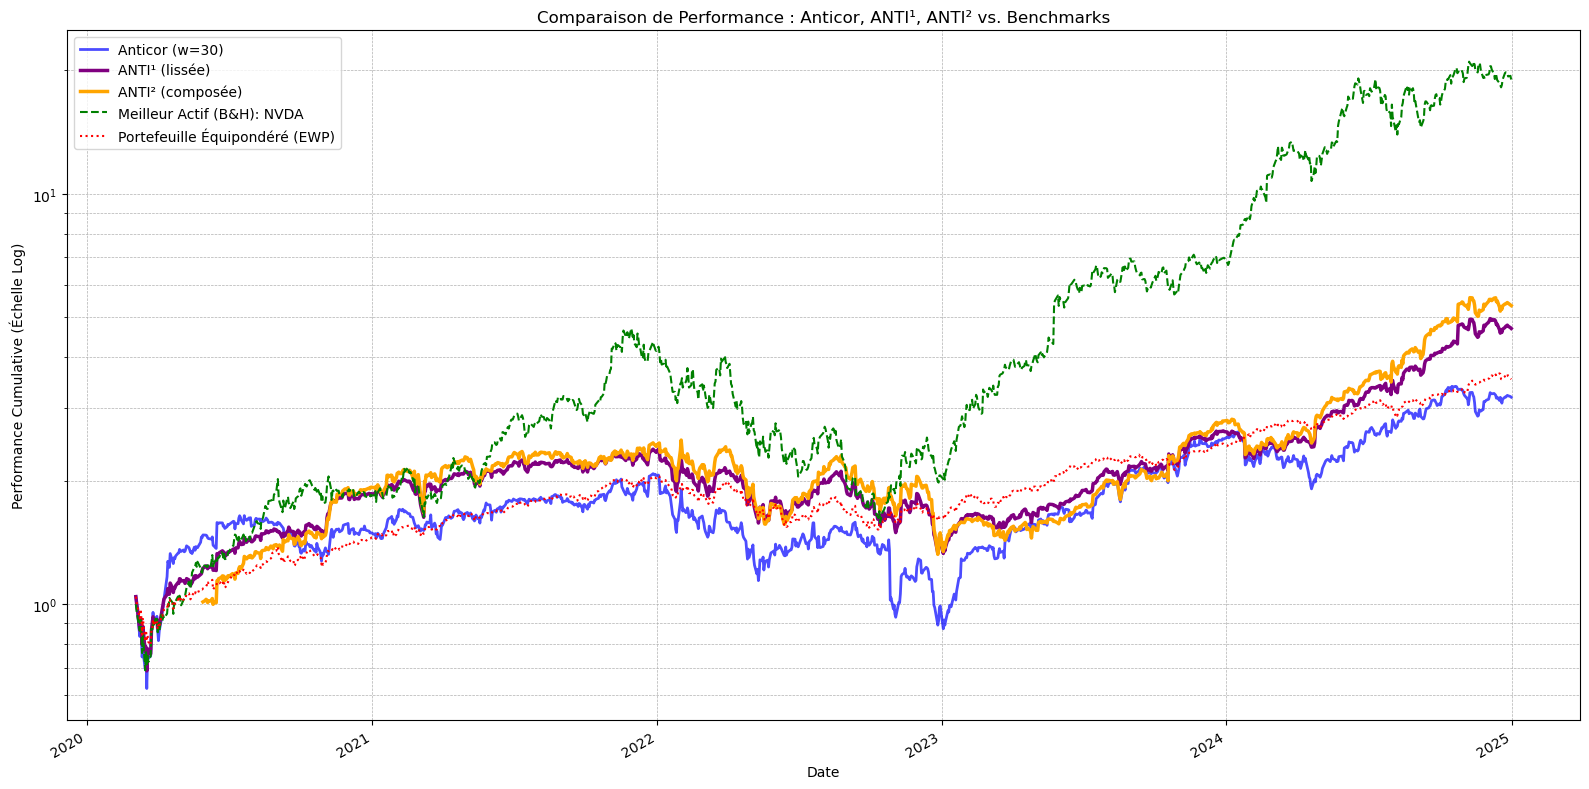

========================= Results Table ANTI2 =========================

✅ Graphique généré et métriques calculées.
                       Rendement Cumulé  Rendement Annualisé  \
Anticor (w=30)                 2.195306             0.272195   
ANTI¹ (lissée)                 3.700552             0.378142   
ANTI² (composée)               4.344258             0.441035   
EWP                            2.534950             0.299108   
Meilleur Actif (NVDA)         17.947088             0.840652   

                       Volatilité Annualisée  Ratio de Sharpe  Max Drawdown  \
Anticor (w=30)                      0.454186         0.599302     -0.581222   
ANTI¹ (lissée)                      0.356545         1.060575     -0.443713   
ANTI² (composée)                    0.369907         1.192286     -0.473396   
EWP                                 0.223312         1.339415     -0.259435   
Meilleur Actif (NVDA)               0.539621         1.557857     -0.663352   

                       R

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("\n📊 Étape 8: Génération du graphique et des indicateurs de performance (avec ANTI²)...")

# --- Création du Graphique ---
fig, ax = plt.subplots(figsize=(16, 8))

# 1. Stratégie Anticor(w=30) (existant)
# Nous devons l'aligner sur la date de début commune
common_start_date = resultats_anti1.index[0] 
anticor_w30_perf = (1 + resultats_strategie['daily_profit']).cumprod()
anticor_w30_perf.loc[common_start_date:].plot(ax=ax, label='Anticor (w=30)', lw=2.0, color='blue', alpha=0.7)

# 2. Stratégie ANTI¹ (lissée) (existant)
resultats_anti1['profit_cumule'].plot(ax=ax, label='ANTI¹ (lissée)', lw=2.5, color='purple')

# 3. Stratégie ANTI² (nouvelle)
resultats_anti2['profit_cumule'].plot(ax=ax, label='ANTI² (composée)', lw=2.5, color='orange')

# 4. Meilleur Actif (B&H) (existant)
best_asset_perf.plot(ax=ax, label=f'Meilleur Actif (B&H): {best_performing_ticker}', linestyle='--', color='green')

# 5. Portefeuille Équipondéré (EWP) (existant)
ewp_perf.plot(ax=ax, label='Portefeuille Équipondéré (EWP)', linestyle=':', color='red')

ax.set_title('Comparaison de Performance : Anticor, ANTI¹, ANTI² vs. Benchmarks')
ax.set_ylabel('Performance Cumulative (Échelle Log)')
ax.set_xlabel('Date')
ax.set_yscale('log')
ax.legend(loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- Calcul et affichage des KPIs (mis à jour) ---

# (Nous supposons que la fonction calculate_performance_metrics est en mémoire)

metrics = {}
metrics['Anticor (w=30)'] = calculate_performance_metrics(resultats_strategie['daily_profit'].loc[common_start_date:])
metrics['ANTI¹ (lissée)'] = calculate_performance_metrics(resultats_anti1['daily_profit'])
metrics['ANTI² (composée)'] = calculate_performance_metrics(resultats_anti2['daily_profit'])
metrics['EWP'] = calculate_performance_metrics(ewp_daily_returns.loc[common_start_date:])
metrics[f'Meilleur Actif ({best_performing_ticker})'] = calculate_performance_metrics(best_asset_perf.pct_change().dropna())

results_table = pd.DataFrame(metrics).T

# Renommer les index pour correspondre exactement à votre tableau de sortie original
results_table = results_table.rename(index={
    f'Meilleur Actif ({best_performing_ticker})': f'Meilleur Actif ({best_performing_ticker})'
})

print("========================= Results Table ANTI2 =========================")
print("\n✅ Graphique généré et métriques calculées.")
print(results_table)